# A manually worked GP

Follows roughly https://www.robots.ox.ac.uk/~mebden/reports/GPtutorial.pdf

## Imports etc

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=1000)

mpl.rcParams.update({
    "figure.dpi": 200,                    
    "font.size": 10,
    # Ticks
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": False,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": False,
    "lines.linewidth" : 0.8,
    "lines.markersize" : 3,


})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Manual basics

[(-1.2, 0.2)]

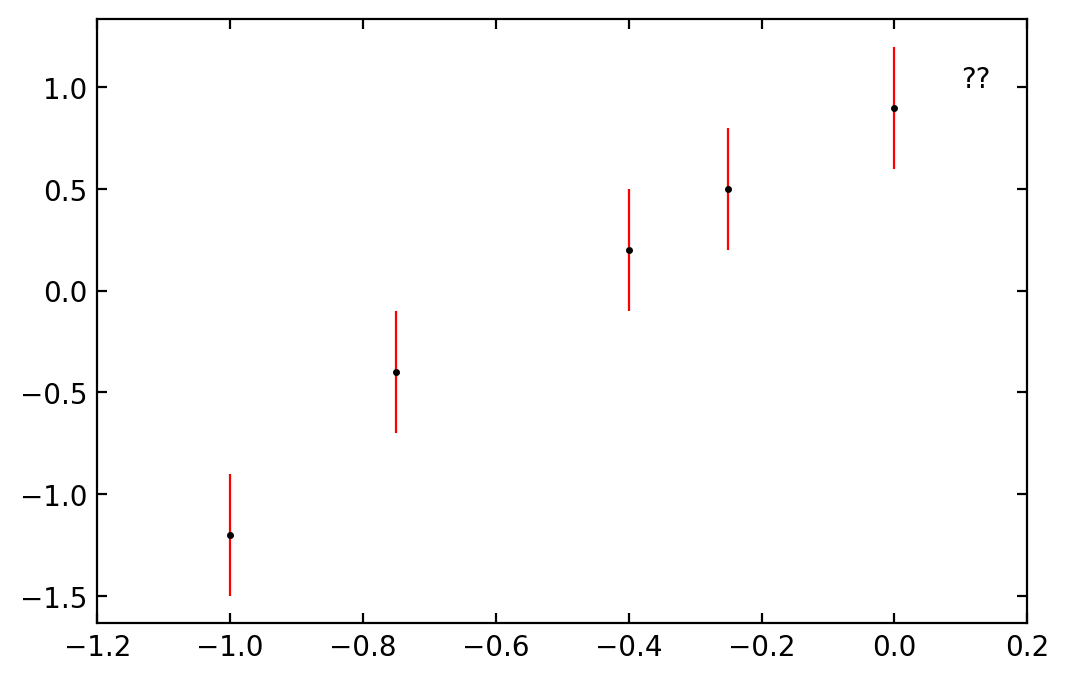

In [38]:
# We have some data with some uncertainty and we want to predict some other data
x = np.array([-1, -0.75, -0.4, -0.25, 0])
y = np.array([-1.2, -0.4, 0.2, 0.5, 0.9])
err = 0.3

_, ax = plt.subplots()
ax.errorbar(x, y, yerr=err, linestyle="", marker=".", color="black", ecolor="red")

goal_x = np.array([0.1])
ax.annotate("??", xy=(0.1, 1.0))
ax.set(xlim=(-1.2, 0.2))

In [66]:
# We can define a covariance function that describes how similar points
# at different locations should be

# There are these two hyperparameters
# How close to 0 our data is. I think this is roughly the range of the middle 2/3 of the data
# If we had no data, our error bars would be at the mean + this and the mean - this
max_covariance = 2
# How quickly our data varies. If this is small, predictions only depend on very nearby objects
# If large, predictions depend on things that are far away.
# Think of it as smoothness. Large length_scale -> smooth function. 
length_scale = 1

def covariance_function(x):
    xCol = np.expand_dims(x, 1)
    xRow = np.expand_dims(x, 0)
    basic_cov = max_covariance * np.exp(-(xRow - xCol)**2/(2*length_scale))
    data_err_cov = np.identity(len(x)) * err**2
    return (basic_cov + data_err_cov)


## Predict a single point

In [40]:
# We can build up the covariance matrix for the known data + the test data
# Also need a mean
mean = 0
cov_matrix = covariance_function(np.concatenate((x, goal_x)))

1.0059846242561221
0.29307019346266827


<ErrorbarContainer object of 3 artists>

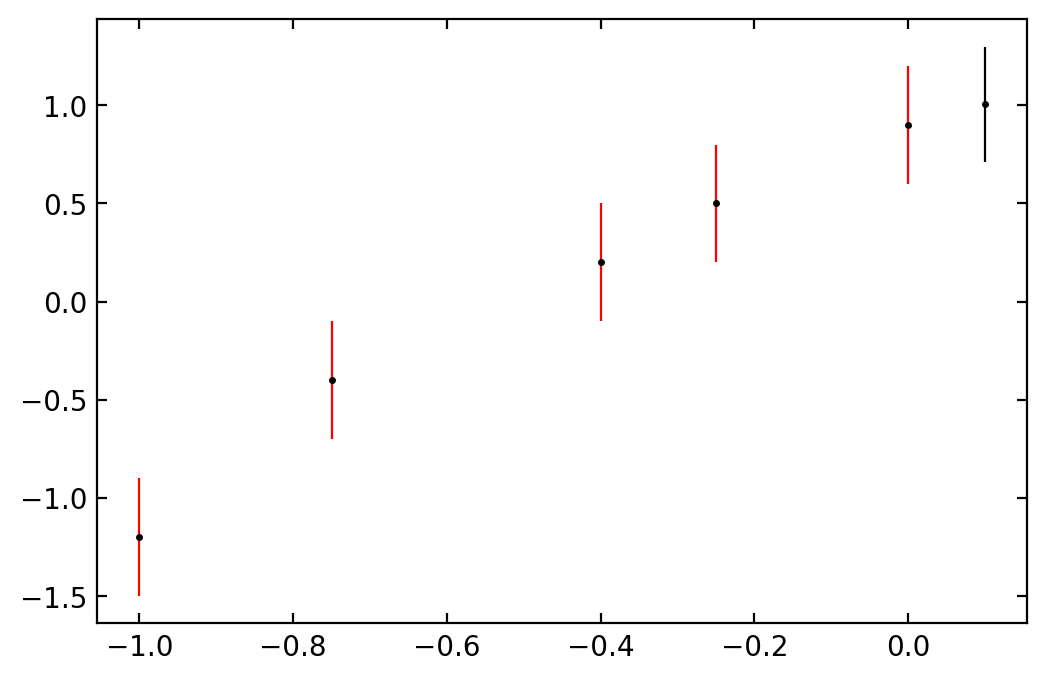

In [44]:
# We now have a mean and a covariance matrix - this is all we need to sample from a mv gaussian
# Our data y values are the samples in the first n dimensions of the mv gaussian
# We now need to take the sample for the final, test dimension.
# However, the probability for draws in that dimension depend on what we got for all the previous draws
# They are correlated
# We (I can't yet...) can do some matrix algebra to find what p(test_y_value | training_y_values)

cov_test_with_data = cov_matrix[-1 ,:-1]
cov_data_with_data = cov_matrix[:-1,:-1]
cov_test_with_test = cov_matrix[-1 , -1]

pred_y = np.dot(cov_test_with_data, np.matmul(np.linalg.inv(cov_data_with_data), y))
print(pred_y)

var_y = cov_test_with_test - np.dot(
    cov_test_with_data, np.matmul(
        np.linalg.inv(cov_data_with_data), cov_test_with_data))
print(var_y)

_, ax = plt.subplots()
ax.errorbar(x, y, yerr=err, linestyle="", marker=".", color="black", ecolor="red")
ax.errorbar(goal_x, [pred_y], yerr=[var_y], marker=".", color="black")
# Not bad...

## Predict a large numpy of data points

In [67]:
# We could do this for single points all over to get the predicted value anywhere.
# But actually the matrix algebra works doing all the points that you want at once.
goals = np.linspace(-1.5, 0.3, num=500)

cov_matrix = covariance_function(np.concatenate((x, goals)))
cut = len(x)
cov_test_with_data = cov_matrix[cut:,:cut]
cov_data_with_data = cov_matrix[:cut,:cut]
cov_test_with_test = cov_matrix[cut:,cut:]

pred_ys = np.matmul(cov_test_with_data, np.matmul(np.linalg.inv(cov_data_with_data), y))

var_ys = cov_test_with_test - np.matmul(cov_test_with_data, 
        np.matmul(np.linalg.inv(cov_data_with_data), cov_test_with_data.T))
var_ys = np.diag(var_ys) # off diagonals are the covariance which we don't care about now

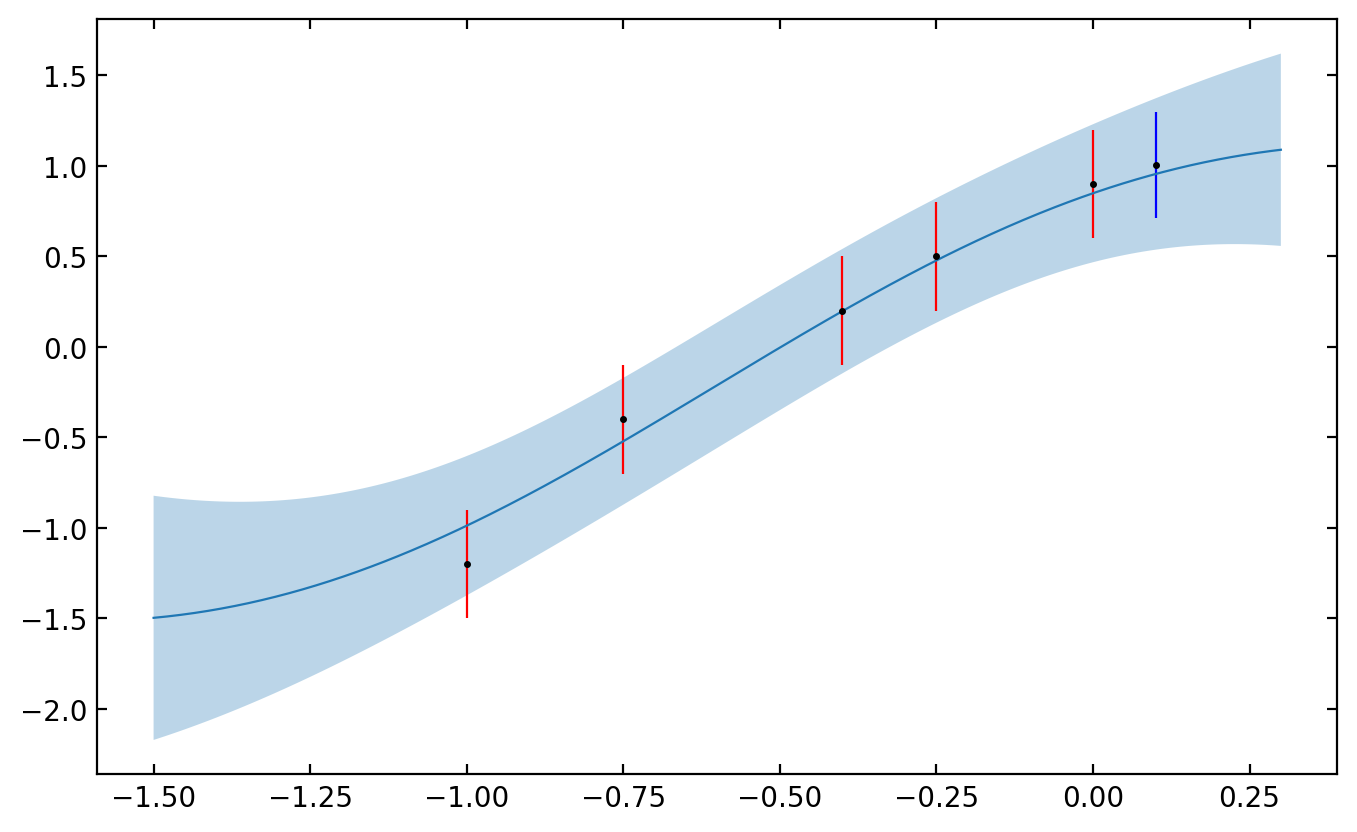

In [68]:
_, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, yerr=err, linestyle="", marker=".", color="black", ecolor="red")
ax.errorbar(goal_x, [pred_y], yerr=[var_y], marker=".", color="black", ecolor="blue")

ax.plot(goals, pred_ys)
ax.fill_between(goals, pred_ys - np.sqrt(var_ys), pred_ys + np.sqrt(var_ys), alpha=0.3)

## Function spaces

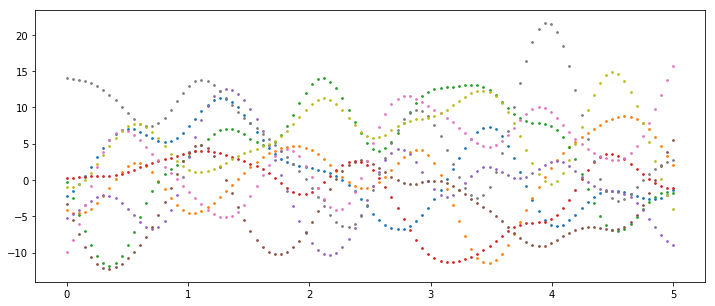

In [128]:
# Lets assume we just have a set of x variables
x = np.linspace(0, 5, 100)

# We also have a covariance function and mean function + hyperparams
max_covariance = 40
length_scale = 0.1

def fs_covariance_function(x):
    xCol = np.expand_dims(x, 1)
    xRow = np.expand_dims(x, 0)
    basic_cov = max_covariance * np.exp(-(xRow - xCol)**2/(2*length_scale))
    return basic_cov

def fs_mean_function(x):
    return np.zeros_like(x)
# We can now generate a covariance matrix and mean vector
cov_matrix = fs_covariance_function(x)
mean_vector = fs_mean_function(x)

# Those fully specify a multivariate gaussian distribution of the same dim as our X
# A draw from these returns our potential Y data
# Currently that Y data is unconstrained (we don't have any training data) except for
# the constraints by the hyperparams.
# e.g. increasing the max_cov increases the range of the function
# increasing the length scale decreases the rate at which the function varies
_, ax = plt.subplots(figsize=(12, 5))
for i in range(9):
    y_pred = np.random.multivariate_normal(mean_vector, cov_matrix)
    ax.scatter(x, y_pred, s=3)

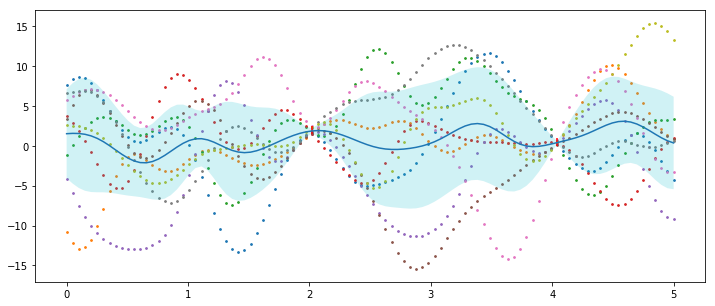

In [129]:
# We can add a couple of observations to constrain the valid functions.
# Let's say that we know that at x = 2 our value is 2 and at x = 4 it is 0, in both cases +/- 0.5
x = np.linspace(0, 5, 100)
idx_2 = np.searchsorted(x, 2)
idx_4 = np.searchsorted(x, 4)

_, ax = plt.subplots(figsize=(12, 5))
ax.errorbar([x[idx_2], x[idx_4]], [2, 0.5], yerr=0.5, color="red", ls="")
num_runs = 9
mean = np.zeros((num_runs, len(x)))
for i in range(num_runs):
    while True:
        y_pred = np.random.multivariate_normal(mean_vector, cov_matrix)
        # This is a simplification. We should prefer things closer to the center and not have a hard cutoff
        # I'm not sure if p(accept) should be a gaussian, in which case we would be biased 
        # closer to the mean function.
        if 1.5 < y_pred[idx_2] < 2.5 and 0 < y_pred[idx_4] < 1:
            break
    ax.scatter(x, y_pred, s=3)
    mean[i] = y_pred

    
# We can match out observations by waiting until be have a mv_gaussian that hits them. This tightly
# constrains points near to our observation and weakly constrains points further away.
# You can imagine that with enough "gates" (data points) to go through, all locations are well constrained.
# This is fantastically slow way of sampling from a mv_gauss with constraints. The linear algebra
# I used above and don't understand is just a fast way of sampling y* given y and a covariance matrix.

# But this is all GP is - given some hyperparams (description of how func should vary) and some
# data constraints (description of gates the func should pass through) we can find all possible
# funcs that satisfy these two criteria.
# By finding all possible solutions, we can then get the mean value of those functions at each point
# We can also find the dispersion in the possible functions and that is the variance.
# Note that above we got the variance by using more linear algebra I don't understand yet. In the same way 
# that you can use the covariance matrix to sample y* you can use it to find the dispersion of possible
# vals at that x.

func_mean = np.mean(mean, axis=0)
func_std = np.std(mean, axis=0)
ax.plot(x, func_mean)
ax.fill_between(x, func_mean - func_std, func_mean + func_std, alpha=0.2)

# Kernel functions

In [7]:
# Factor out what we have already seen into conventient GP helpers
import gp_helpers.manual_gp as gp

In [8]:
# So far we have seen kernel functions that specify that points near to each other should be similar.
# We have also seen a piece of a kernel function that does something with data errors. I don't understand this.
# But what about data that has some other pattern? Maybe it is periodic?

f = np.sin
err = 0.2

all_x = np.linspace(0, 30*np.pi, num=200)
#x = np.linspace(0, 30*np.pi, num=100)
x = np.random.random(size=100) * 30 * np.pi
y = f(x) + np.random.normal(0, err, size=len(x))

## Squared Exp

[[1.00000000e+000 9.50305227e-086 6.72972939e-097 ... 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [9.50305227e-086 1.00000000e+000 0.00000000e+000 ... 4.27036739e-267 1.06621341e-281 1.08534524e-296]
 [6.72972939e-097 0.00000000e+000 1.00000000e+000 ... 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 4.27036739e-267 0.00000000e+000 ... 1.00000000e+000 6.38516952e-001 1.66222469e-001]
 [0.00000000e+000 1.06621341e-281 0.00000000e+000 ... 6.38516952e-001 1.00000000e+000 6.38516952e-001]
 [0.00000000e+000 1.08534524e-296 0.00000000e+000 ... 1.66222469e-001 6.38516952e-001 1.00000000e+000]]


485521.78117080877

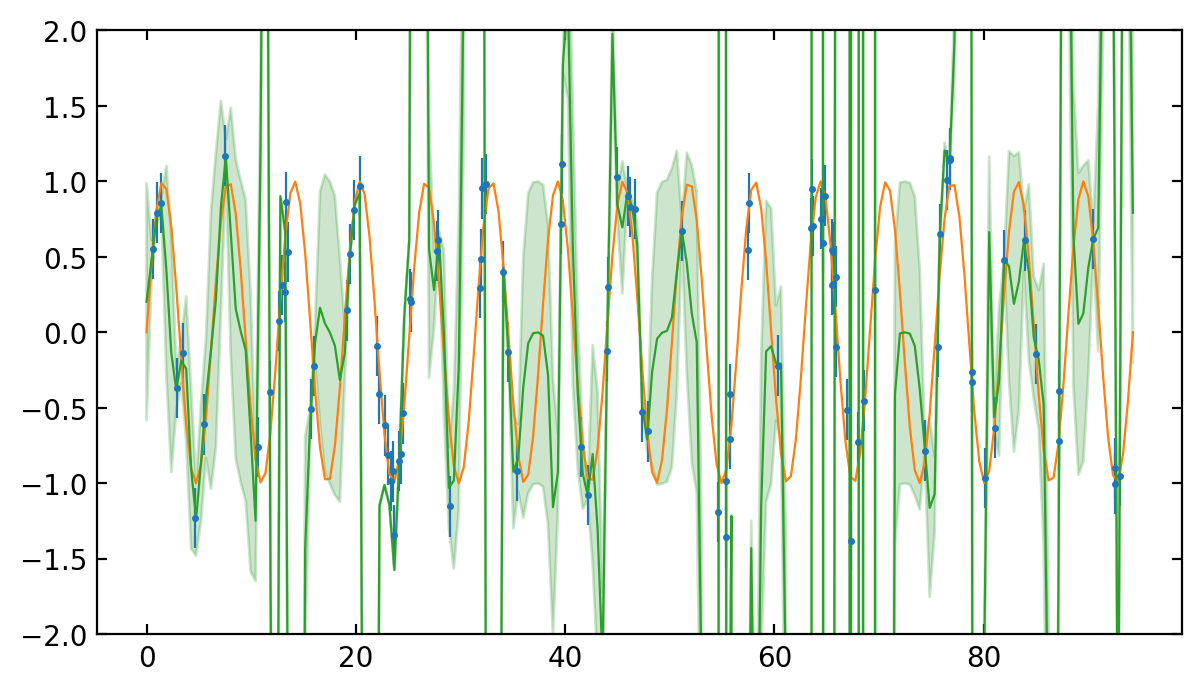

In [23]:
# This hideously underestimates the errors as it needs to hit exactly all of the
def squared_exponential(x, length_scale, max_covariance):
    return max_covariance * np.exp(-(np.expand_dims(x, 0) - np.expand_dims(x, 1))**2/(2*length_scale**2))
    
pred_ys, var_ys = gp.build_gp_model(x, y, all_x, squared_exponential, l_scale=0.5, max_cov=1)
var_ys = np.abs(var_ys)
ax = gp.plot(x, y, err, f, all_x, pred_ys, var_ys)
np.sum((f(all_x) - pred_ys)**2)/len(pred_ys)

## Squared Exp with error term

[[1.04000000e+000 9.50305227e-086 6.72972939e-097 ... 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [9.50305227e-086 1.04000000e+000 0.00000000e+000 ... 4.27036739e-267 1.06621341e-281 1.08534524e-296]
 [6.72972939e-097 0.00000000e+000 1.04000000e+000 ... 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 4.27036739e-267 0.00000000e+000 ... 1.00000000e+000 6.38516952e-001 1.66222469e-001]
 [0.00000000e+000 1.06621341e-281 0.00000000e+000 ... 6.38516952e-001 1.00000000e+000 6.38516952e-001]
 [0.00000000e+000 1.08534524e-296 0.00000000e+000 ... 1.66222469e-001 6.38516952e-001 1.00000000e+000]]


0.19167374046792518

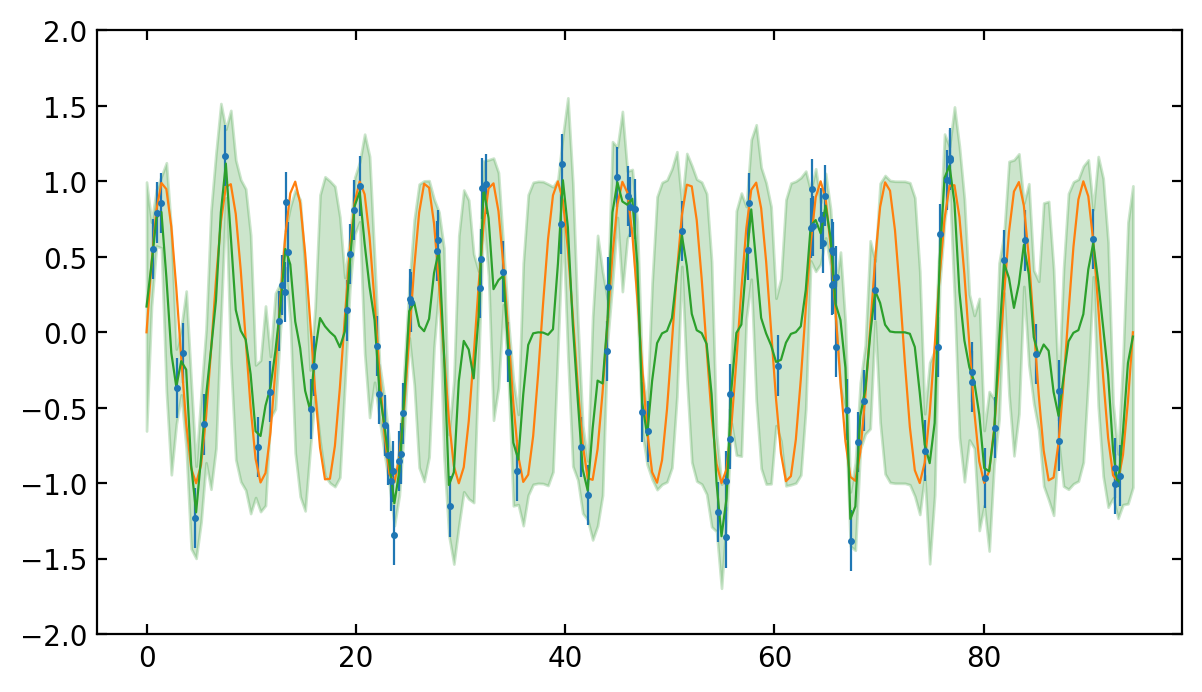

In [17]:
# By doing this, the diagonal has a slightly larger covariance. The off diagonal doesn't change.
# Specifically, it goes from max_covariance -> max_covariance + err**2
def squared_exponential_w_err(x, length_scale, max_covariance, err, train_len):
    se = squared_exponential(x, length_scale, max_covariance)
    data_err = np.zeros((len(x),len(x)))
    for i in range(train_len): data_err[i][i] = err**2 # We don't want to add this to the test data
    return se + data_err

pred_ys, var_ys = gp.build_gp_model(x, y, all_x, squared_exponential_w_err, l_scale=0.5, max_cov=1, err=err, train_len=len(x))
ax = gp.plot(x, y, err, f, all_x, pred_ys, var_ys)
np.sum((f(all_x) - pred_ys)**2)/len(pred_ys)

### Toy showing why we need the error term

[[1.         0.96923323 0.99221794]
 [0.96923323 1.         0.99221794]
 [0.99221794 0.99221794 1.        ]]
[0.15764718] [0.01104798]
[[1.0025     0.96923323 0.99221794]
 [0.96923323 1.0025     0.99221794]
 [0.99221794 0.99221794 1.        ]]
[0.15744729] [0.03728033]
[[1.0025     0.96923323 0.96923323 ... 0.89568863 0.88917245 0.8824969 ]
 [0.96923323 1.0025     0.8824969  ... 0.97622177 0.97283518 0.96923323]
 [0.96923323 0.8824969  1.         ... 0.77200877 0.76346534 0.7548396 ]
 ...
 [0.89568863 0.97622177 0.77200877 ... 1.         0.99988287 0.99953155]
 [0.88917245 0.97283518 0.76346534 ... 0.99988287 1.         0.99988287]
 [0.8824969  0.96923323 0.7548396  ... 0.99953155 0.99988287 1.        ]]


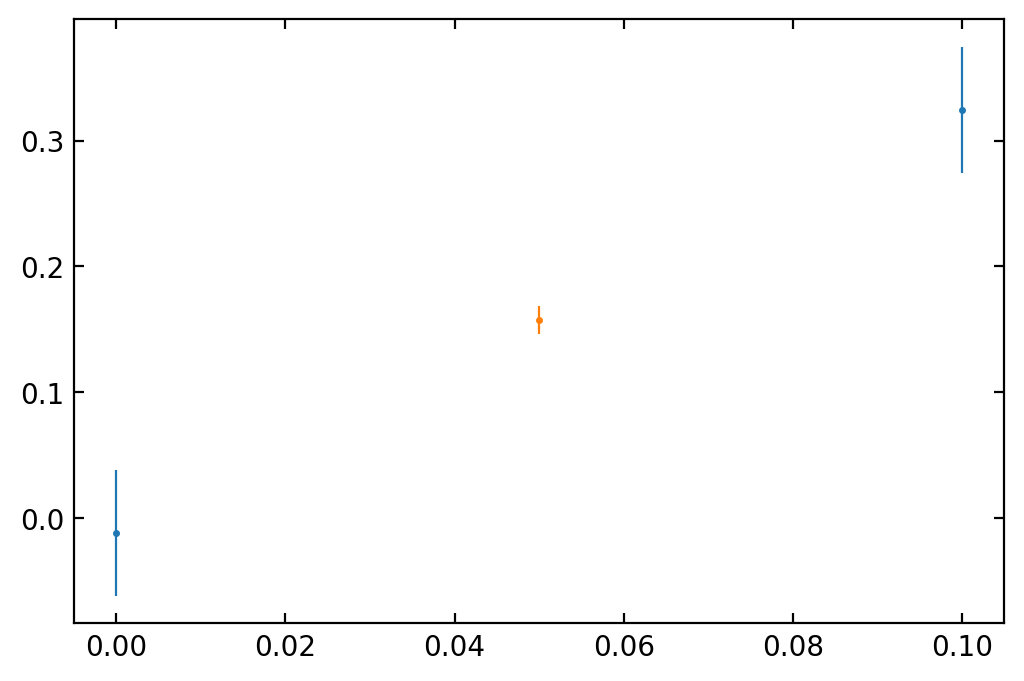

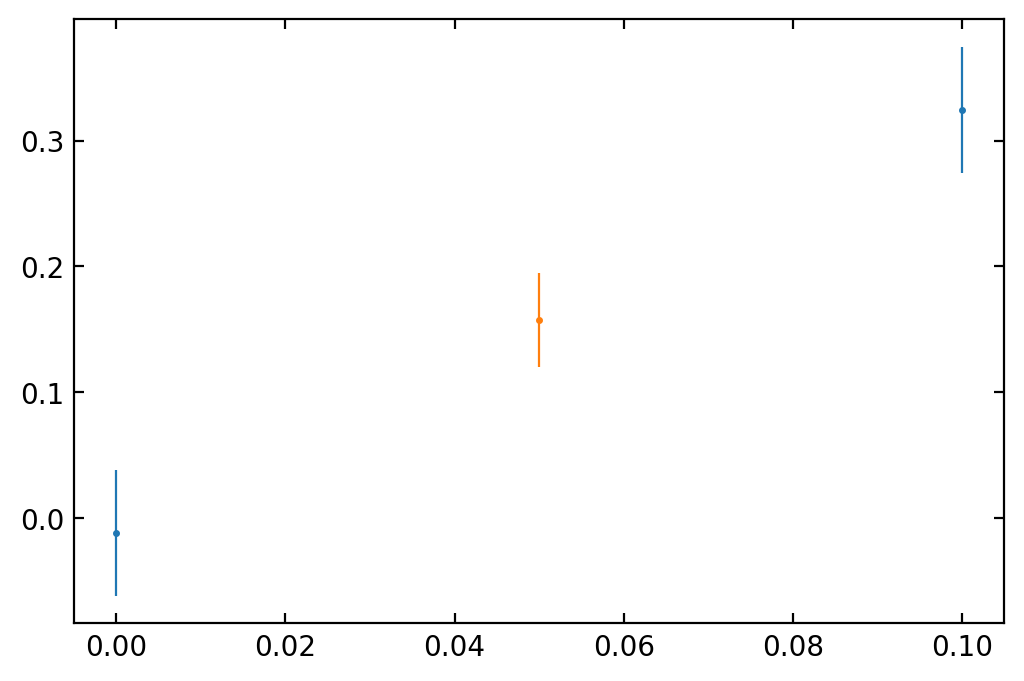

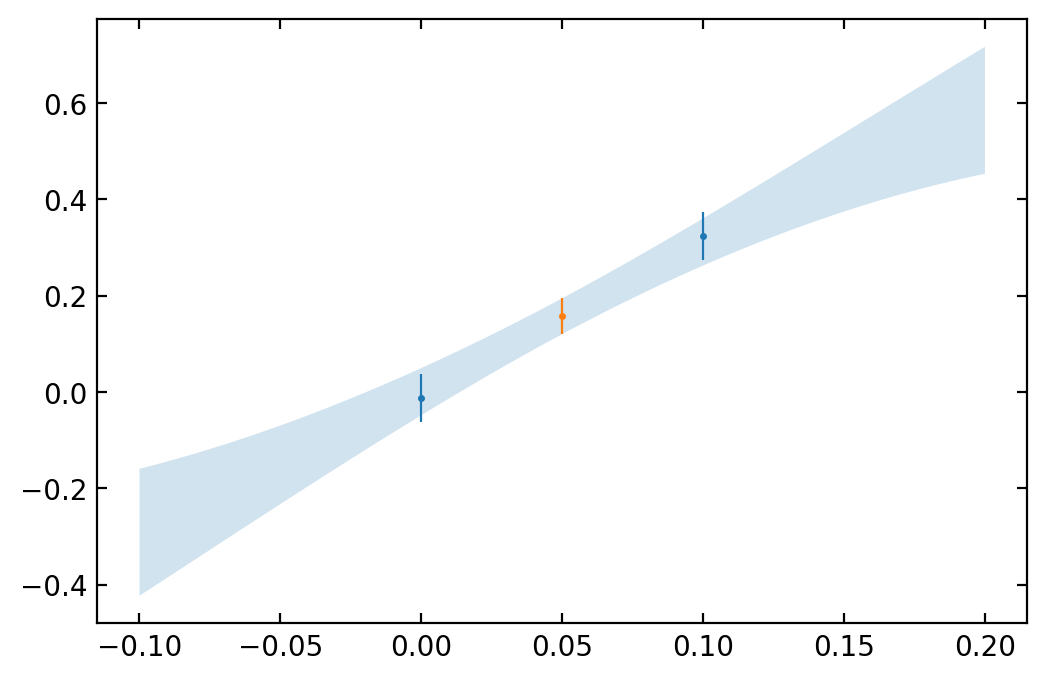

In [361]:
# Toy model to explain why we need the error term
def f(x):
    return 3*x
t_x = np.array([0, 0.1])
t_y = f(t_x)
err = 0.05
t_y += np.random.normal(0, err, size = 2) # with noise


gp_x = np.array([0.05])

for i in range(2):
    if i == 0:
        gp_y, gp_var = gp.build_gp_model(t_x, t_y, gp_x, squared_exponential, l_scale=0.4, max_cov=1)
    else:
        gp_y, gp_var = gp.build_gp_model(t_x, t_y, gp_x, squared_exponential_w_err, l_scale=0.4, max_cov=1, err=err, train_len=len(t_x))

    print(gp_y, np.sqrt(gp_var))
    
    _, ax = plt.subplots()
    ax.errorbar(t_x, t_y, yerr=err, ls="", marker=".")
    ax.errorbar(gp_x, gp_y, yerr=np.sqrt(gp_var), ls="", marker=".")
    
l_x = np.linspace(-0.1, 0.2)

l_y, l_var = gp.build_gp_model(t_x, t_y, l_x, squared_exponential_w_err, l_scale=0.4, max_cov=1, err=err, train_len=len(t_x))
_, ax = plt.subplots()
ax.errorbar(t_x, t_y, yerr=err, ls="", marker=".")
ax.errorbar(gp_x, gp_y, yerr=np.sqrt(gp_var), ls="", marker=".")
ax.fill_between(l_x, l_y - np.sqrt(l_var), l_y + np.sqrt(l_var), alpha=0.2)

## Periodic

[[2.04       0.15076171 0.23324567 ... 0.19284802 0.14617109 0.13575331]
 [0.15076171 2.04       0.36942489 ... 0.46352583 0.70427983 0.92752953]
 [0.23324567 0.36942489 2.04       ... 0.97422662 0.78910595 0.54031745]
 ...
 [0.19284802 0.46352583 0.97422662 ... 2.         1.53428745 0.82586785]
 [0.14617109 0.70427983 0.78910595 ... 1.53428745 2.         1.53428745]
 [0.13575331 0.92752953 0.54031745 ... 0.82586785 1.53428745 2.        ]]


0.03356158967883768

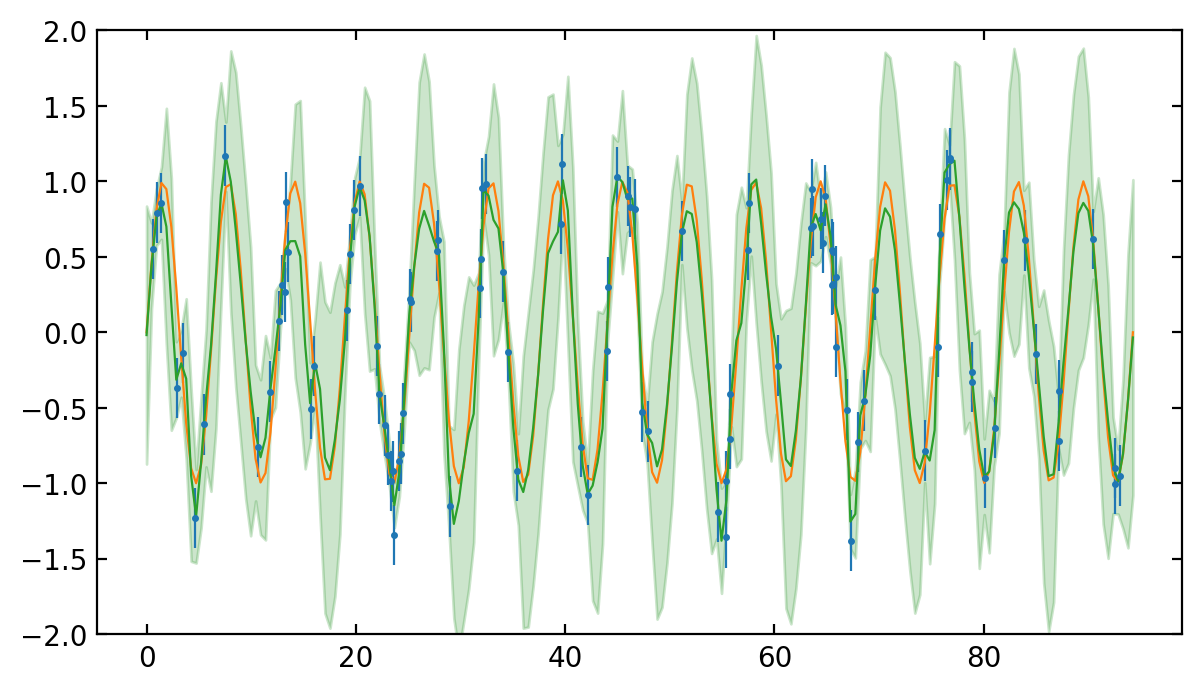

In [32]:
# What if we know what we are trying to fit is periodic, and we know the period? We then want to encode 
# in our kernel that the value of each point should not only depend on points near to it but also to points
# in similar phase

def periodic(x, length_scale, max_covariance, err, train_len, freq):
    se_w_err = squared_exponential_w_err(x, length_scale, max_covariance, err, train_len)
    p = np.exp(-2*np.sin(
        (np.expand_dims(x, 0) - np.expand_dims(x, 1)) * freq # Whole numbers -> in phase. Z + 1/2 -> completely out of phase
        * np.pi # Therefore make sure sin(...) = 0 for whole numbers and = 1 for Z + 1/2
    )**2)
    return se_w_err + p

pred_ys, var_ys = gp.build_gp_model(x, y, all_x, periodic, l_scale=0.5, max_cov=1, err=err, train_len=len(x), freq=1/(2*np.pi))
ax = gp.plot(x, y, err, f, all_x, pred_ys, var_ys)

np.sum((f(all_x) - pred_ys)**2)/len(pred_ys)

# Interesting behaviour

## The model has smaller errors on the data points and often has the smallest error between the data points.

I think this makes sense. If you have two data points very close together you can say that the value of a point in between them should be ~ the mean of the two we know.
The std-dev on the mean `sqrt(2*err^2)/2 = err / sqrt(2)` (remember that in general errors on the mean go as `1/sqrt(n)`.

On the data points, we can use some info from nearby points to reduce error.

[[1.0001     0.99995    0.99995    ... 0.99980122 0.99980062 0.99980002]
 [0.99995    1.0001     0.99980002 ... 0.9999506  0.9999503  0.99995   ]
 [0.99995    0.99980002 1.         ... 0.9995519  0.999551   0.9995501 ]
 ...
 [0.99980122 0.9999506  0.9995519  ... 1.         1.         1.        ]
 [0.99980062 0.9999503  0.999551   ... 1.         1.         1.        ]
 [0.99980002 0.99995    0.9995501  ... 1.         1.         1.        ]]


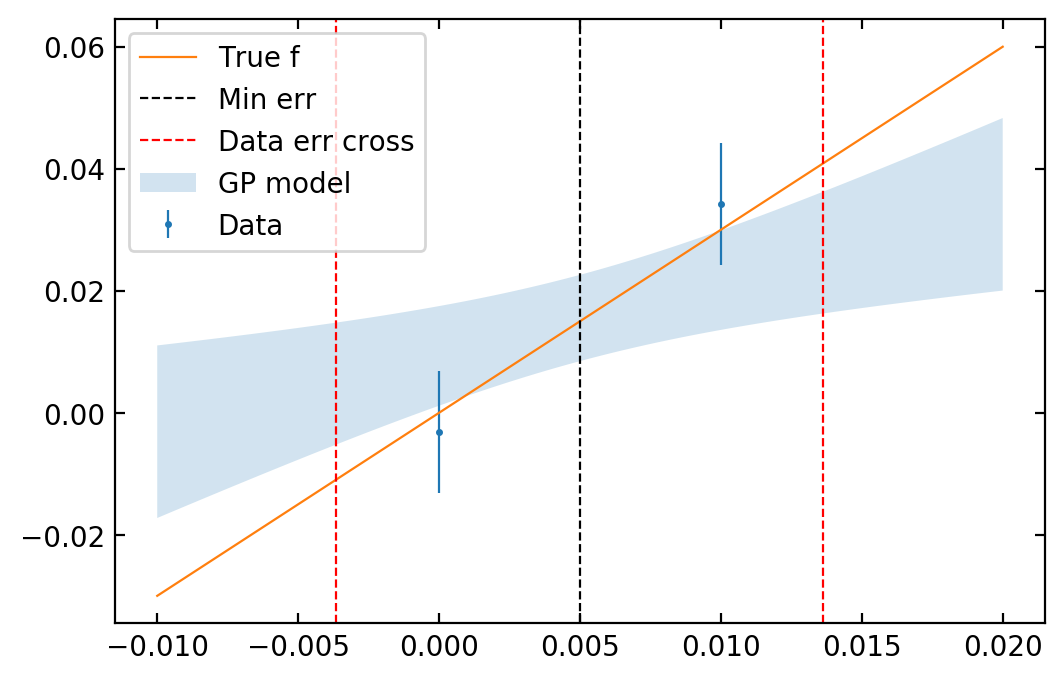

In [100]:
# Linear model + training set
def f(x):
    return 3*x
t_x = np.array([0, 0.01])
t_y = f(t_x)
err = 0.01
t_y += np.random.normal(0, err, size = 2) # with noise

# Test set
l_x = np.linspace(-0.01, 0.02, num=1000)

l_y, l_var = gp.build_gp_model(t_x, t_y, l_x, squared_exponential_w_err, l_scale=1, max_cov=1, err=err, train_len=len(t_x))
_, ax = plt.subplots()
ax.errorbar(t_x, t_y, yerr=err, ls="", marker=".", label="Data")
ax.fill_between(l_x, l_y - np.sqrt(l_var), l_y + np.sqrt(l_var), alpha=0.2, label="GP model")
ax.plot(l_x, f(l_x), label="True f")
assert np.isclose(err/np.sqrt(2), np.min(np.sqrt(l_var)), atol=0.001)

ax.axvline(l_x[np.argmin(np.sqrt(l_var))], ls="--", color="black", label="Min err")

crs = np.nonzero(np.diff(np.sign(np.sqrt(l_var) - err)))[0]
ax.axvline(l_x[crs[0]], ls="--", color="red", label="Data err cross")
ax.axvline(l_x[crs[1]], ls="--", color="red")
ax.legend()

# Higher dimensions

So far we have only looked at a 1d input. What happens if the input is a vector?

This change is actually absurdly trivial. All we need to generate the predictions is the covariance matrix. So we just need a covariance function that handles vector inputs. Easy!

In [165]:
from mpl_toolkits.mplot3d import Axes3D

def f(x, y):
    return x + 4*np.sin(y)

train_x = np.arange(-1, 1, 0.1)
train_y = np.arange(-2, 3, 0.5)
train_xx, train_yy = np.meshgrid(train_x, train_y)#, sparse=True)
#train_xx, train_yy = train_xx.flatten(), train_yy.flatten()
train_r = f(train_xx, train_yy) + np.random.normal(0, 0.1, len(train_x) * len(train_y)).reshape((len(train_y), len(train_x)))

ax = plt.subplot(projection='3d')
ax.scatter(train_xx, train_yy, train_r)
ax.plot_wireframe(train_xx, train_yy, train_r)


test_x = np.arange(-1, 1, 0.05)
test_y = np.arange(-2, 3, 0.01)
test_xx, test_yy = np.meshgrid(test_x, test_y)

test_in = np.concatenate((
    np.expand_dims(test_xx, 2)
    np.expand_dims(test_yy, 2)))#, axis=2).reshape((len(test_x), len(test_y), -1))

def squared_exponential(x_vec, length_scale, max_covariance):
    return max_covariance * np.exp(-(np.expand_dims(x, 0) - np.expand_dims(x, 1))**2/(2*length_scale**2))

def mv_squared_exponential_w_err(x_vec, length_scale, max_covariance, err, train_len):
    se = squared_exponential(x_vec, length_scale, max_covariance)
    
    data_err = np.zeros((len(x),len(x)))
    for i in range(train_len): data_err[i][i] = err**2 # We don't want to add this to the test data
    return se + data_err

print(test_in.shape)

SyntaxError: invalid syntax (<ipython-input-165-a6f11096c985>, line 23)